### Remove scroll from figures

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Extend the size of the Window

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Load Modules

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
import netCDF4 as nc
import glob
import numpy as np
import pandas as pd
import xarray as xr
import itertools
import cftime
import cartopy.crs as ccrs
from datetime import datetime

import colorcet as cc

import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm.notebook import tqdm

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import random
from jax.experimental import mesh_utils
from jax.sharding import PositionalSharding

import numpyro
numpyro.enable_x64()
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.contrib.nested_sampling import NestedSampler

import dill


INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


## Read CMIP Data into xarray

In [5]:
# Define paths
geoDataPath = '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/**/'
save_path = '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.nc'

In [6]:
# Find files
geoFiles = glob.glob(geoDataPath + '*.nc', recursive=True)
geoFiles


['/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1985.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1986.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1987.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1988.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1989.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1990.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1991.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1992.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1993.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1994.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1995.nc',

### Create variables for geo run

In [7]:

# geo_data = None
# for file in geoFiles:
#     if geo_data is None:
#         geo_data = xr.open_dataset(file)
#     else:
#         geo_data = geo_data.combine_first(xr.open_dataset(file))

# geo_data.to_netcdf(save_path)


In [8]:
geo_data = xr.open_dataset(save_path)
# geo_data['air'] = geo_data['air'] -273.15
geo_data

<xarray.Dataset> Size: 1GB
Dimensions:    (time: 16710, nbnds: 2, level: 1, lat: 94, lon: 192)
Coordinates:
  * level      (level) float32 4B 2.0
  * lat        (lat) float32 376B 88.54 86.65 84.75 ... -84.75 -86.65 -88.54
  * lon        (lon) float32 768B 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * time       (time) datetime64[ns] 134kB 1979-01-01 1979-01-02 ... 2024-09-30
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] 267kB ...
    air        (time, level, lat, lon) float32 1GB ...
Attributes:
    Conventions:    CF-1.0
    title:          Daily NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2002/03 by RHS (netCDF2.3)\nConverted to chunked,...

### Explore seasonal function family based on powers of sines

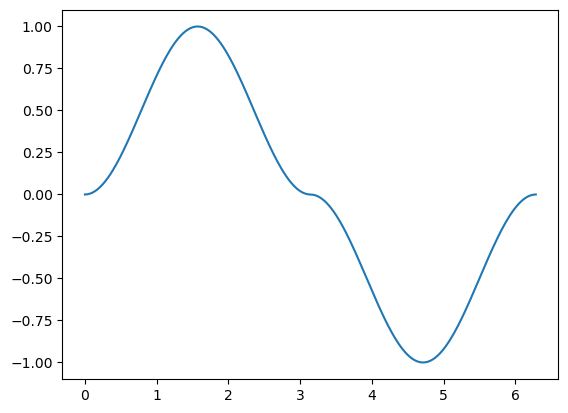

In [9]:
x = np.linspace(0,1,360)*2*np.pi
plt.plot(x, np.sign(np.sin(x))*(np.abs(np.sin(x)))**2)

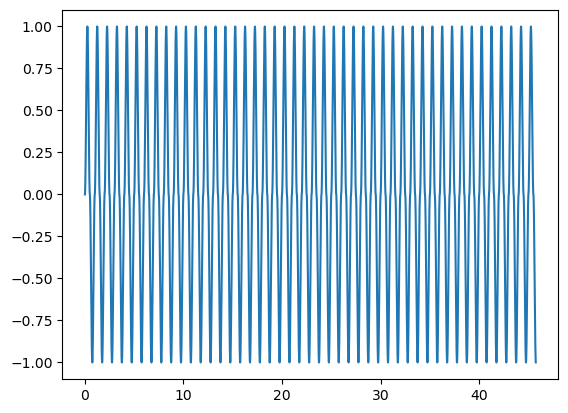

In [10]:
orbits = ((geo_data.time-np.min(geo_data.time))/np.timedelta64(1, 'D')/365.256).values

plt.plot(orbits, np.sign(np.sin(orbits*2*np.pi))*(np.abs(np.sin(orbits*2*np.pi)))**2)

### Rebin data to coarser grids

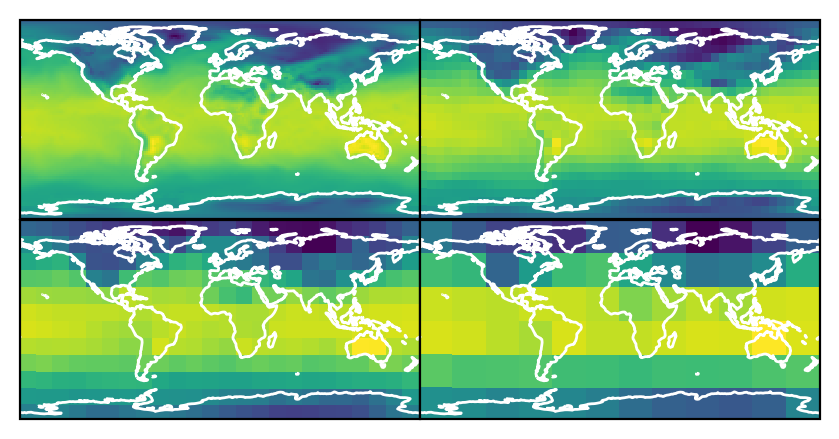

In [11]:
vmin = None
vmax = None

fig = plt.figure(figsize=2*np.array([2, 1]), dpi=200)
gs0 = fig.add_gridspec(2, 2, wspace=0.0, hspace=0, left=0, right=1, bottom=0, top=1)

ax = fig.add_subplot(gs0[0, 0], projection=ccrs.PlateCarree())
geo_data.air.isel(time=0).plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, add_labels=False)
ax.coastlines(color='w')

geo_data_coarse8 = geo_data.coarsen(lon=4, lat=4, boundary='pad').mean()
ax = fig.add_subplot(gs0[0, 1], projection=ccrs.PlateCarree())
geo_data_coarse8.air.isel(time=0).plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, add_labels=False)
ax.coastlines(color='w')

geo_data_coarse15 = geo_data.coarsen(lon=8, lat=8, boundary='pad').mean()
ax = fig.add_subplot(gs0[1, 0], projection=ccrs.PlateCarree())
geo_data_coarse15.air.isel(time=0).plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, add_labels=False)
ax.coastlines(color='w')

geo_data_coarse30 = geo_data.coarsen(lon=16, lat=16, boundary='pad').mean()
ax = fig.add_subplot(gs0[1, 1], projection=ccrs.PlateCarree())
geo_data_coarse30.air.isel(time=0).plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, add_labels=False)
ax.coastlines(color='w')

In [12]:
geo_data_coarse30

<xarray.Dataset> Size: 5MB
Dimensions:    (time: 16710, nbnds: 2, level: 1, lat: 6, lon: 12)
Coordinates:
  * level      (level) float32 4B 2.0
  * lat        (lat) float32 24B 74.28 43.81 13.33 -17.14 -47.62 -76.18
  * lon        (lon) float32 48B 14.06 44.06 74.06 104.1 ... 284.1 314.1 344.1
  * time       (time) datetime64[ns] 134kB 1979-01-01 1979-01-02 ... 2024-09-30
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] 267kB 1979-01-01 ... 2024-10-01
    air        (time, level, lat, lon) float32 5MB 256.0 245.3 ... 252.0 250.5
Attributes:
    Conventions:    CF-1.0
    title:          Daily NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2002/03 by RHS (netCDF2.3)\nConverted to chunked,...

### Read CO2 concentration

<xarray.Dataset> Size: 247kB
Dimensions:  (time: 15464)
Coordinates:
  * time     (time) datetime64[ns] 124kB 1974-05-19 1974-05-20 ... 2024-10-24
Data variables:
    CO2      (time) float64 124kB 333.5 333.6 333.5 333.2 ... 422.0 422.1 422.1

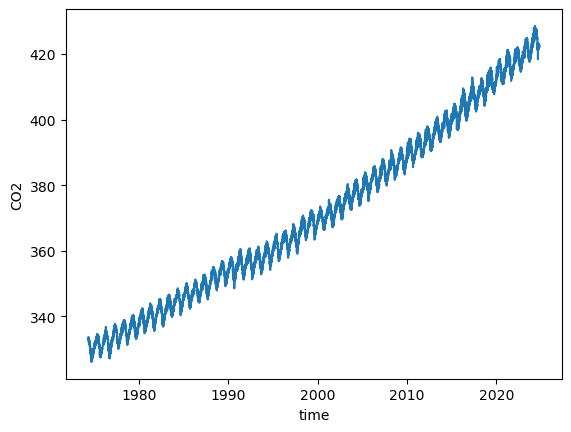

In [13]:
df = pd.read_csv('/d0/amunozj/git_repos/interconnection-sun-climate/co2_daily_mlo.csv', engine="c", header=32)
df['time'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df = df.set_index('time', drop=True).loc[:,['CO2']]

co2_data = xr.Dataset.from_dataframe(df)
# co2_data = co2_data.interp(time=geo_data_coarse30.time.values)
co2_data.CO2.plot()
co2_data

### Read El Niño index

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3095881/57781222.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_table('/d0/amunozj/git_repos/interconnection-sun-climate/ENI/detrend.nino34.ascii.txt', engine="c", sep='\s+')


<xarray.Dataset> Size: 36kB
Dimensions:     (time: 897)
Coordinates:
  * time        (time) datetime64[ns] 7kB 1950-01-15 1950-02-15 ... 2024-09-15
Data variables:
    TOTAL       (time) float64 7kB 24.56 25.07 25.88 26.29 ... 27.34 26.74 26.44
    ClimAdjust  (time) float64 7kB 26.18 26.39 26.95 27.39 ... 27.29 26.86 26.72
    oni         (time) float64 7kB -1.62 -1.32 -1.07 -1.1 ... 0.05 -0.12 -0.28
    normalized  (time) float64 7kB -1.904 -1.555 -1.264 ... -0.1576 -0.3439

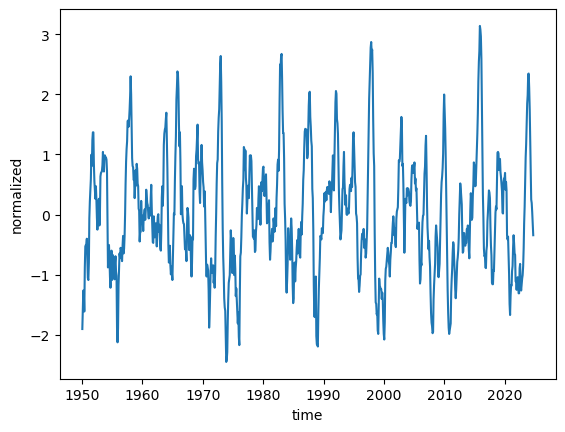

In [14]:
df = pd.read_table('/d0/amunozj/git_repos/interconnection-sun-climate/ENI/detrend.nino34.ascii.txt', engine="c", sep='\s+')
df['DAY'] = 15
df['time'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
df = df.set_index('time', drop=True).loc[:,['TOTAL', 'ClimAdjust']]

oni_data = xr.Dataset.from_dataframe(df)
# oni_data = oni_data.interp(time=geo_data_coarse30.time.values, kwargs={'fill_value':'extrapolate'})
# oni_data.ClimAdjust.plot()
# oni_data.TOTAL.plot()

oni_data['oni'] = oni_data.TOTAL - oni_data.ClimAdjust
oni_data['normalized'] = (oni_data.oni - oni_data.oni.mean())/oni_data.oni.std()


oni_data.normalized.plot()
oni_data

<xarray.Dataset> Size: 41kB
Dimensions:               (time: 725)
Coordinates:
  * time                  (time) datetime64[ns] 6kB 1964-05-01 ... 2024-09-01
Data variables:
    Timestamp             (time) object 6kB '1964-05-01T00:00:00Z' ... '2024-...
    FractionalDate        (time) float64 6kB 1.964e+03 1.964e+03 ... 2.025e+03
    UncorrectedCountRate  (time) int64 6kB 5945 6008 6059 ... 5637 5553 5176
    CorrectedCountRate    (time) int64 6kB 6424 6427 6461 ... 5983 5848 5715
    Pressure              (time) float64 6kB 1.011e+03 1.009e+03 ... 1.014e+03
    normalized            (time) float64 6kB 0.6251 0.6333 ... -0.9525 -1.317

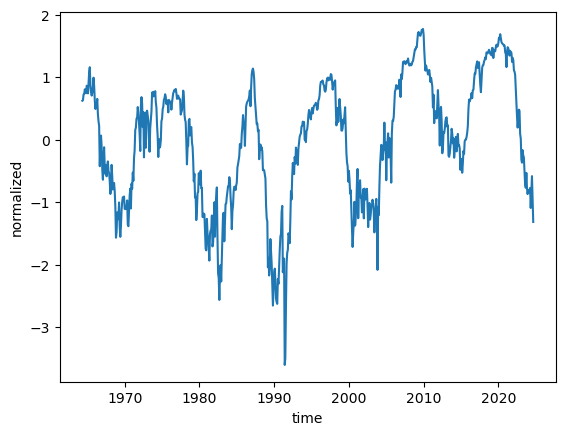

In [15]:
# Define path
crDataPath = '../../data/cosmic_rays/OULU_1964_05_01 _00_00_2024_10_28 _23_30.csv'

# Read cr monthly average file with custom column names\
cr = pd.read_csv(crDataPath)
cr['time'] = pd.to_datetime(cr['Timestamp']).dt.tz_localize(None).astype('datetime64[ns]')
cr = cr.set_index('time', drop=True)
cr = xr.Dataset.from_dataframe(cr)
# cr['crav'] = cr['CorrectedCountRate[cts/min]'].rolling(time=365, min_periods=1, center=True).mean()
# cr = cr.sel(time=slice(np.min(hist_sol.time.data)-pd.Timedelta(0, 'd'), np.max(hist_sol.time.data)))

# # Convert to seasonal average
# cr = cr['CorrectedCountRate[cts/min]'].resample(time='QS-DEC').mean().to_dataset(name = 'cr')

# # Reset index to middle of the season
# cr['time'] = cr['time'] + pd.to_timedelta(45, 'd')
# # Select only whole seasons
# cr = cr.sel(time=slice('1983-01-01', '2022-09-30'))
# cr['time'] = xr.CFTimeIndex.to_datetimeindex(cr['time'], unsafe=True)

cr['normalized'] = (cr.CorrectedCountRate - cr.CorrectedCountRate.mean())/cr.CorrectedCountRate.std()
cr.normalized.plot()

cr

## Read output of NC fits

In [130]:
DATA_LABEL = "air_temperature"
MCMC_OUT_FOLDER = (
    f"/d0/amunozj/git_repos/interconnection-sun-climate/outputs/nested_sampling"
)
coarsen_level = 2
geo_data_coarse = geo_data.coarsen(lon=coarsen_level, lat=coarsen_level, boundary='pad').mean()

results_co2_season = []
results_co2_season_oni = []
results_co2_season_cr = []
results_co2_season_oni_cr = []

output_folder = os.path.join(MCMC_OUT_FOLDER, f"level_{coarsen_level}")
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

pbar2 = tqdm(
    range(geo_data_coarse.lon.shape[0]),
    position=0,
    total=geo_data_coarse.lon.shape[0],
    leave=False,
)
for lon_index in pbar2:
    pbar2.set_postfix_str(
        f"Processing {geo_data_coarse.lon.values[lon_index]}° longitude",
        refresh=True,
    )

    pbar3 = tqdm(
        range(geo_data_coarse.lat.shape[0]),
        position=1,
        total=geo_data_coarse.lat.shape[0],
        leave=False,
    )
    for lat_index in pbar3:
        pbar3.set_postfix_str(
            f"Processing {geo_data_coarse.lat.values[lat_index]}° latitude",
            refresh=True,
        )

        # Run with only co2 increase and seasonal variation
        output_file = os.path.join(
            output_folder,
            f"{DATA_LABEL}_level{coarsen_level}_co2_season_lat_{lat_index}_lon_{lon_index}.pkl",
        )
        if os.path.isfile(output_file):

            #TODO consolidate data
            samples = dill.load(open(output_file, "rb"))

            reduced_results_co2_season = {}
            reduced_results_co2_season['lat'] = geo_data_coarse.lat.values[lat_index]
            reduced_results_co2_season['lon'] = geo_data_coarse.lon.values[lon_index]
            reduced_results_co2_season['log_Z_mean'] = samples['log_Z_mean'].item()
            for key in samples.keys():
                if key != 'log_Z_mean':
                    reduced_results_co2_season[key] = np.median(samples[key])

            results_co2_season.append(reduced_results_co2_season)


        # Run with co2 increase, seasonal variation, and ONI
        output_file = os.path.join(
            output_folder,
            f"{DATA_LABEL}_level{coarsen_level}_co2_season_oni_lat_{lat_index}_lon_{lon_index}.pkl",
        )
        if os.path.isfile(output_file):
            #TODO consolidate data
            samples = dill.load(open(output_file, "rb"))

            reduced_results_co2_season_oni = {}
            reduced_results_co2_season_oni['lat'] = geo_data_coarse.lat.values[lat_index]
            reduced_results_co2_season_oni['lon'] = geo_data_coarse.lon.values[lon_index]
            reduced_results_co2_season_oni['log_Z_mean'] = samples['log_Z_mean'].item()
            for key in samples.keys():
                if key != 'log_Z_mean':
                    reduced_results_co2_season_oni[key] = np.median(samples[key])

            results_co2_season_oni.append(reduced_results_co2_season_oni)

        # # Run with co2 increase, seasonal variation, and cr
        output_file = os.path.join(
            output_folder,
            f"{DATA_LABEL}_level{coarsen_level}_co2_season_cr_lat_{lat_index}_lon_{lon_index}.pkl",
        )
        if os.path.isfile(output_file):
            #TODO consolidate data
            samples = dill.load(open(output_file, "rb"))

            reduced_results_co2_season_cr = {}
            reduced_results_co2_season_cr['lat'] = geo_data_coarse.lat.values[lat_index]
            reduced_results_co2_season_cr['lon'] = geo_data_coarse.lon.values[lon_index]
            reduced_results_co2_season_cr['log_Z_mean'] = samples['log_Z_mean'].item()
            for key in samples.keys():
                if key != 'log_Z_mean':
                    reduced_results_co2_season_cr[key] = np.median(samples[key])

            results_co2_season_cr.append(reduced_results_co2_season_cr)
            
        # Run with co2 increase, seasonal variation, oni, and cr
        output_file = os.path.join(
            output_folder,
            f"{DATA_LABEL}_level{coarsen_level}_co2_season_oni_cr_lat_{lat_index}_lon_{lon_index}.pkl",
        )
        if os.path.isfile(output_file):
            #TODO consolidate data
            samples = dill.load(open(output_file, "rb"))

            reduced_results_co2_season_oni_cr = {}
            reduced_results_co2_season_oni_cr['lat'] = geo_data_coarse.lat.values[lat_index]
            reduced_results_co2_season_oni_cr['lon'] = geo_data_coarse.lon.values[lon_index]
            reduced_results_co2_season_oni_cr['log_Z_mean'] = samples['log_Z_mean'].item()
            for key in samples.keys():
                if key != 'log_Z_mean':
                    reduced_results_co2_season_oni_cr[key] = np.median(samples[key])

            results_co2_season_oni_cr.append(reduced_results_co2_season_oni_cr)

In [131]:
df_co2_season = pd.DataFrame(results_co2_season).sort_values(['lat', 'lon']).set_index(['lat', 'lon'], drop=True, verify_integrity=True).to_xarray()
df_co2_season_oni = pd.DataFrame(results_co2_season_oni).sort_values(['lat', 'lon']).set_index(['lat', 'lon'], drop=True, verify_integrity=True).to_xarray()
df_co2_season_cr = pd.DataFrame(results_co2_season_cr).sort_values(['lat', 'lon']).set_index(['lat', 'lon'], drop=True, verify_integrity=True).to_xarray()
df_co2_season_oni_cr = pd.DataFrame(results_co2_season_oni_cr).sort_values(['lat', 'lon']).set_index(['lat', 'lon'], drop=True, verify_integrity=True).to_xarray()

In [170]:
df_joint = xr.concat([df_co2_season, df_co2_season_oni, df_co2_season_cr, df_co2_season_oni_cr], pd.Index(['co2_yr', 'co2_yr_oni', 'co2_yr_cr', 'co2_yr_oni_cr'], name='model'))
df_joint

<xarray.Dataset> Size: 2MB
Dimensions:             (model: 4, lat: 47, lon: 96)
Coordinates:
  * lat                 (lat) float32 188B -87.6 -83.8 -80.0 ... 80.0 83.8 87.6
  * lon                 (lon) float32 384B 0.9375 4.688 8.438 ... 353.4 357.2
  * model               (model) object 32B 'co2_yr' ... 'co2_yr_oni_cr'
Data variables:
    log_Z_mean          (model, lat, lon) float64 144kB -5.429e+04 ... -5.332...
    co2_gain            (model, lat, lon) float64 144kB 1.755 1.721 ... 4.88
    offset              (model, lat, lon) float64 144kB 230.4 229.9 ... 255.3
    seasonal_amplitude  (model, lat, lon) float64 144kB -11.63 11.71 ... 13.7
    seasonal_exponent   (model, lat, lon) float64 144kB 1.332 1.307 ... 0.7324
    seasonal_shift      (model, lat, lon) float64 144kB 0.2516 0.7513 ... 1.301
    sigma               (model, lat, lon) float64 144kB 6.22 6.324 ... 5.87
    oni_gain            (model, lat, lon) float64 144kB nan nan ... -0.3654
    oni_shift           (model, lat, lon) float64 144kB nan nan ... -5.938 6.041
    cr_gain             (model, lat, lon) float64 144kB nan nan ... -0.1004
    cr_shift            (model, lat, lon) float64 144kB nan nan ... -0.9953

In [171]:
df_joint.model[0].values.item()

'co2_yr'

(-62709.333851913, -9463.715922316022)

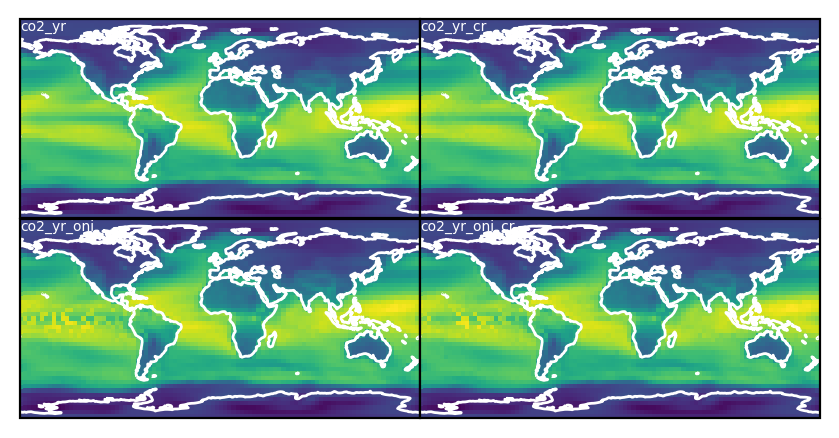

In [172]:
vmin = df_joint.log_Z_mean.min().values.item()
vmax = df_joint.log_Z_mean.max().values.item()

fig = plt.figure(figsize=2*np.array([2, 1]), dpi=200)
gs0 = fig.add_gridspec(2, 2, wspace=0.0, hspace=0, left=0, right=1, bottom=0, top=1)

for i in range(2):
    for j in range(2):
        n = i + 2*j
        model = df_joint.model[n].values.item()

        ax = fig.add_subplot(gs0[i, j], projection=ccrs.PlateCarree())
        df_joint.log_Z_mean.sel(model=model).plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, add_labels=False)
        ax.coastlines(color='w')
        ax.text(0, 1, model, ha='left', va='top', transform=ax.transAxes, c='w', fontsize=5)
        
(vmin, vmax)

### Find Bayesian Probability

In [173]:
df_joint['Log_BF'] = df_joint.log_Z_mean - df_joint.log_Z_mean.max(dim='model')
df_joint['Prob'] = np.exp(df_joint.Log_BF)/np.exp(df_joint.Log_BF).sum(dim='model')
df_joint

<xarray.Dataset> Size: 2MB
Dimensions:             (model: 4, lat: 47, lon: 96)
Coordinates:
  * lat                 (lat) float32 188B -87.6 -83.8 -80.0 ... 80.0 83.8 87.6
  * lon                 (lon) float32 384B 0.9375 4.688 8.438 ... 353.4 357.2
  * model               (model) object 32B 'co2_yr' ... 'co2_yr_oni_cr'
Data variables: (12/13)
    log_Z_mean          (model, lat, lon) float64 144kB -5.429e+04 ... -5.332...
    co2_gain            (model, lat, lon) float64 144kB 1.755 1.721 ... 4.88
    offset              (model, lat, lon) float64 144kB 230.4 229.9 ... 255.3
    seasonal_amplitude  (model, lat, lon) float64 144kB -11.63 11.71 ... 13.7
    seasonal_exponent   (model, lat, lon) float64 144kB 1.332 1.307 ... 0.7324
    seasonal_shift      (model, lat, lon) float64 144kB 0.2516 0.7513 ... 1.301
    ...                  ...
    oni_gain            (model, lat, lon) float64 144kB nan nan ... -0.3654
    oni_shift           (model, lat, lon) float64 144kB nan nan ... -5.938 6.041
    cr_gain             (model, lat, lon) float64 144kB nan nan ... -0.1004
    cr_shift            (model, lat, lon) float64 144kB nan nan ... -0.9953
    Log_BF              (model, lat, lon) float64 144kB -8.135 -3.45 ... 0.0 0.0
    Prob                (model, lat, lon) float64 144kB 0.0002561 0.0189 ... 1.0

In [179]:
df_joint['mdl_1'] = df_joint.Prob.idxmax(dim='model')
df_joint['mdl_1_inx'] = df_joint.Prob.max(dim='model').astype(int)*0
for n in range(4):
    model = df_joint.model[n].values.item()
    df_joint['mdl_1_inx'] = xr.where(df_joint['mdl_1']==model, n, df_joint['mdl_1_inx'])
df_joint

<xarray.Dataset> Size: 2MB
Dimensions:             (model: 4, lat: 47, lon: 96)
Coordinates:
  * lat                 (lat) float32 188B -87.6 -83.8 -80.0 ... 80.0 83.8 87.6
  * lon                 (lon) float32 384B 0.9375 4.688 8.438 ... 353.4 357.2
  * model               (model) object 32B 'co2_yr' ... 'co2_yr_oni_cr'
Data variables: (12/16)
    log_Z_mean          (model, lat, lon) float64 144kB -5.429e+04 ... -5.332...
    co2_gain            (model, lat, lon) float64 144kB 1.755 1.721 ... 4.88
    offset              (model, lat, lon) float64 144kB 230.4 229.9 ... 255.3
    seasonal_amplitude  (model, lat, lon) float64 144kB -11.63 11.71 ... 13.7
    seasonal_exponent   (model, lat, lon) float64 144kB 1.332 1.307 ... 0.7324
    seasonal_shift      (model, lat, lon) float64 144kB 0.2516 0.7513 ... 1.301
    ...                  ...
    cr_shift            (model, lat, lon) float64 144kB nan nan ... -0.9953
    Log_BF              (model, lat, lon) float64 144kB -8.135 -3.45 ... 0.0 0.0
    Prob                (model, lat, lon) float64 144kB 0.0002561 0.0189 ... 1.0
    model_1             (lat, lon) object 36kB 'co2_yr_cr' ... 'co2_yr_oni_cr'
    mdl_1               (lat, lon) object 36kB 'co2_yr_cr' ... 'co2_yr_oni_cr'
    mdl_1_inx           (lat, lon) int64 36kB 2 2 1 0 2 3 3 3 ... 2 3 1 1 0 3 3

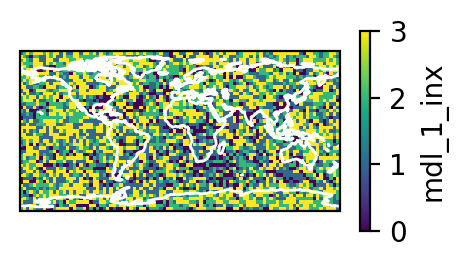

In [ ]:
fig = plt.figure(figsize=2*np.array([2, 1]), dpi=200)
gs0 = fig.add_gridspec(2, 2, wspace=0.0, hspace=0, left=0, right=1, bottom=0, top=1)

ax = fig.add_subplot(gs0[0, 0], projection=ccrs.PlateCarree())
df_joint.mdl_1_inx.plot(cmap=cc.cm.colorwheel)
ax.coastlines(color='w')